## BBM 409 - Programming Assignment 3

* You can add as many cells as you want in-between each question.
* Please add comments to your code to explain your work.  
* Please add Markdown cells to answer the (non-coding) questions in the homework text. You can, however, refer to the outputs of code cells without adding them as images to the Markdown cell unless you are requested to do otherwise.
* Please be careful about the order of runs of cells. Doing the homework, it is likely that you will be running the cells in different orders, however, they will be evaluated in the order they appear. Hence, please try running the cells in this order before submission to make sure they work.    
* Please refer to the homework text for any implementation detail. Though you are somewhat expected to abide by the comments in the below cells, they are mainly just provided for guidance. That is, as long as you are not completely off this structure and your work pattern is understandable and traceable, it is fine. For instance, you do not have to implement a particular function within a cell just because the comment directs you to do so.
* This document is also your report. Show your work.

###  Insert personal information (irem, saygı, 2200356103)

## 1. Implementing a CNN from Scratch (40 points)

### 1.1. Introduction
* **Brief overview of the task.**

This section focuses on implementing a basic Convolutional Neural Network (CNN) from scratch using PyTorch to classify images into ten animal categories. The task involves designing a CNN architecture with fundamental components like convolutional layers, activation functions, pooling layers, and a fully connected layer. The provided Animals-10 Dataset includes 4,500 images categorized into ten classes, with a balanced split for training, validation, and testing.

* **Answer the questions like, What are the main components of a CNN architecture?, Why we use this in image classification?, etc.**

**Main Components of a CNN Architecture**

***Convolutional Layers:*** Extract features from images by applying filters to detect patterns like edges, textures, or shapes.

***Activation Functions (e.g., ReLU):*** Introduce non-linearity to the model, enabling it to learn complex patterns.

***Pooling Layers (e.g., Max Pooling):*** Downsample feature maps to reduce dimensionality and computational load while retaining important features.

***Fully Connected Layer:*** Maps extracted features to output classes, providing the final classification results.
Flattening Layer: Converts 2D feature maps into a 1D vector to input into fully connected layers.

***Loss Function:*** Measures the difference between predicted and actual class labels (e.g., Cross-Entropy Loss for multi-class classification).

***Optimizer (e.g., SGD or Adam):*** Updates model weights during training to minimize the loss function.

**Why Use CNNs in Image Classification?**

CNNs are highly effective for image classification tasks because they exploit spatial hierarchies in data through convolutional layers, allowing the model to identify patterns such as edges and textures. They automatically extract and learn features from images, eliminating the need for manual feature engineering. Additionally, CNNs achieve invariance to transformations like scaling, rotation, and translation by leveraging pooling and convolutional operations, making them robust for various image inputs.

* **Description of the dataset used for classification.**

The Animals-10 Dataset contains 4,500 labeled images of 10 different animal species, each class represented by a separate folder. The dataset is pre-organized into 300 images per class for training (total 3,000 images), and 75 images per class for both validation and testing (total 750 images each). The images vary in size and are preprocessed by:

Resizing to a uniform size of 256x256 pixels.

Normalization to scale pixel values, improving convergence during training.

Transformations such as random flips or rotations to augment the dataset and enhance generalization.


### 1.2. Data Loading and Preprocessing (3 points)

In [ ]:
## Import necessary libraries

import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import random_split
import os


In [ ]:
## Load the dataset using PyTorch's data loading utilities
## Apply necessary preprocessing such as resizing and normalization
## Divide the dataset into training, validation, and testing subsets
import zipfile
from google.colab import files, drive
# I am uploading the ZIP file to the Colab environment
uploaded = files.upload()



Saving pa3_subset_animal.zip to pa3_subset_animal.zip


In [ ]:

# Extracting the ZIP file
for filename in uploaded.keys():
    if filename.endswith(".zip"):
        zip_path = filename  # Getting the uploaded ZIP file name
        extract_path = os.path.join('/content/pa3_subset_animal')  # Defining where to extract the files
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(extract_path)  # Extracting the files to the target directory

# Extracting the ZIP file again (if needed)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# I am collecting valid classes that contain image files
valid_classes = []
for item in os.listdir(extract_path):
    item_path = os.path.join(extract_path, item)
    if os.path.isdir(item_path):
        # Checking if the directory contains images
        if any(file.endswith(('.png', '.jpg', '.jpeg')) for file in os.listdir(item_path)):
            valid_classes.append(item)

# Creating a filtered dataset directory
filtered_root = os.path.join(extract_path, "filtered_dataset")


os.makedirs(filtered_root, exist_ok=True)

# Creating symbolic links for valid classes in the filtered dataset directory
for cls in valid_classes:
    cls_path = os.path.join(extract_path, cls)
    target_path = os.path.join(filtered_root, cls)

    if not os.path.exists(target_path): # Avoid duplicate symbolic links
        os.symlink(cls_path, target_path)
    else:
        print(f"Symbolic link for '{cls}' already exists. Skipping.")

for root, dirs, files in os.walk(extract_path):
    print(f"Directory: {root}")
    print(f"Subdirectories: {dirs}")
    print(f"Files: {files}")
    print()


# Defining the target size for resizing
target_size = 256

# Defining transformations
transform = transforms.Compose([
    transforms.Resize((target_size, target_size)),  # Resizing to 256x256
    transforms.ToTensor(),  # Converting to tensor
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalizing to [-1, 1]
])

correct_root = '/content/pa3_subset_animal/pa3_subset_animal'

# Loading the dataset and apply the defined transformations
dataset = torchvision.datasets.ImageFolder(root=correct_root, transform=transform)

print(len(dataset.classes))
# Calculate the number of images per class for the split
num_classes = len(dataset.classes)
images_per_class = len(dataset) // num_classes
train_per_class = 300
val_test_per_class = 75


# Create indices for the splitting the dataset
indices = torch.randperm(len(dataset))
train_indices = []
val_indices = []
test_indices = []

# Assign indices to training, validation, and test datasets
start_index = 0
for _ in range(num_classes):
    train_indices.extend(indices[start_index:start_index + train_per_class])
    val_indices.extend(indices[start_index + train_per_class:start_index + train_per_class + val_test_per_class])
    test_indices.extend(indices[start_index + train_per_class + val_test_per_class:start_index + train_per_class + 2 * val_test_per_class])
    start_index += images_per_class



# Create subset datasets using the calculated indices
train_dataset = torch.utils.data.Subset(dataset, train_indices)
val_dataset = torch.utils.data.Subset(dataset, val_indices)
test_dataset = torch.utils.data.Subset(dataset, test_indices)

print(f"Total classes in dataset: {dataset.classes}")


# Print the sizes of the datasets to verify
print("Training dataset size:", len(train_dataset))
print("Validation dataset size:", len(val_dataset))
print("Test dataset size:", len(test_dataset))

# Creating data loaders for each dataset
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=False)



Directory: /content/pa3_subset_animal
Subdirectories: ['filtered_dataset', 'pa3_subset_animal']
Files: []

Directory: /content/pa3_subset_animal/filtered_dataset
Subdirectories: []
Files: []

Directory: /content/pa3_subset_animal/pa3_subset_animal
Subdirectories: ['ragno', 'elefante', 'cavallo', 'scoiattolo', 'cane', 'gatto', 'farfalla', 'mucca', 'pecora', 'gallina']
Files: []

Directory: /content/pa3_subset_animal/pa3_subset_animal/ragno
Subdirectories: []
Files: ['OIP--Jlmaq5hQ1WBTLmue4gLRQHaFj.jpeg', 'OIP-q0SqZAjHxLPE4qSW70lMzwHaE8.jpeg', 'OIP-6FiqYvdIYUPqmx6Z-sx1JwAAAA.jpeg', 'OIP-z7uZ1Tit_T_2BmRjzYuuiwElEs.jpeg', 'OIP-i8sl_EA-Bg-VngKOwe94PAHaFT.jpeg', 'OIP-KZz9-YcsHwYxbBR2O_p63AHaFj.jpeg', 'OIP-7piNdI1ATkuGoHtPfsmaRgHaE8.jpeg', 'OIP-jnvOrvIyNO-s7QyyNNu7wwHaJT.jpeg', 'OIP-Mx1w4PgwBd-68Me2CDRzcAHaH1.jpeg', 'OIP-oxE-_hr0AEcLKXsbzPQMggHaE9.jpeg', 'OIP-0Ivnzv3__K8m_klHuBVFpAHaFi.jpeg', 'OIP-peFQLcSZtRq2OhYtQ3kVAAHaHH.jpeg', 'OIP-6Oyby29J8t30mFRjIa99KgHaHX.jpeg', 'OIP-DdmqTXPKgTeoeqzBuB

### 1.3. Define your CNN architecture (7 points)
* **Explain the reason behind your architecture.**

The architecture was designed to effectively analyze and classify animal images while keeping a good balance between complexity and performance. It starts with layers that learn simple patterns like edges and gradually moves to deeper layers that capture more detailed and specific features of the animals. The number of filters increases as the layers go deeper to ensure the model can focus on finer details while the image size gets smaller. Batch normalization helps the model train faster and more reliably, while the ReLU activation ensures it can learn complex relationships in the data. Max pooling simplifies the model’s computations by keeping the most important features and avoiding overfitting. Finally, fully connected layers bring all the learned features together to make accurate predictions, with dropout added to prevent the model from relying too much on specific features. This thoughtful design ensures the model is flexible, efficient, and capable of delivering good results.

* **Explain your choice of activation functions.**

I choosed ReLU as the activation function because it’s simple and efficient. It works by setting any negative values to zero, making it quick to compute. Unlike other activation functions like sigmoid or tanh, ReLU doesn’t get stuck when dealing with large input values, which helps the model train faster and more reliably. It also makes the model more efficient by deactivating certain neurons with negative inputs, which reduces complexity and helps the model generalize better to new data. These qualities make ReLU a great choice for building a model that learns effectively and performs well on classification tasks.

In [ ]:
## Design a CNN architecture with at least 3 and at most 6 convolutional layers
## Add activation functions (e.g., ReLU) after each convolutional layer
## Intersperse pooling layers (e.g., max pooling) to reduce spatial dimensions
## Add a fully connected layer at the end to map features to output classes
import torch
import torch.nn as nn

class CustomCNN(nn.Module):
    def __init__(self, num_classes, input_size):
        super(CustomCNN, self).__init__()

        # Here, I define the feature extraction layers, which include convolutional and pooling layers.
        self.features = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1),   # First convolutional layer
            nn.BatchNorm2d(64), # Adding batch normalization to speed up training
            nn.ReLU(),  # Applying ReLU activation
            nn.MaxPool2d(kernel_size=2, stride=2),  # First max pooling to reduce spatial dimensions

            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),  # Second convolutional layer
            nn.BatchNorm2d(128),  # Batch normalization again
            nn.ReLU(),   # ReLU activation
            nn.MaxPool2d(kernel_size=2, stride=2),  # Second max pooling layer

            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),  # Third convolutional layer
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Third max pooling layer

            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1), # Fourth convolutional layer
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Fourth max pooling layer

            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1), # Fifth convolutional layer
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2) # Fifth max pooling layer
        )

        # I calculate the flatten size dynamically based on the input size.
        self.flatten_size = self._get_flatten_size(input_size)

        # Here, I define the fully connected layers that will handle classification.
        self.fc = nn.Sequential(
            nn.Flatten(), # Flattening the output of the convolutional layers
            nn.Linear(self.flatten_size, 4096), # First fully connected layer
            nn.ReLU(),
            nn.Dropout(0.5),  # Adding dropout for regularization
            nn.Linear(4096, 1024),  # Second fully connected layer
            nn.ReLU(),
            nn.Dropout(0.5),  # Dropout again for regularization
            nn.Linear(1024, num_classes)  # Final output layer, where the number of units equals the number of classes
        )

    def _get_flatten_size(self, input_size):
        # This function helps me compute the size of the flattened tensor dynamically
        with torch.no_grad():
            dummy_input = torch.zeros(1, 3, *input_size)  # I create a dummy input tensor with the same dimensions as the input
            output = self.features(dummy_input) # Pass this dummy input through the feature extraction layers
            return output.view(-1).size(0)  # Flatten the output and get its size

    def forward(self, x):
      # Here, I define the forward pass of the network
        x = self.features(x)  # First, pass the input through the convolutional layers
        x = self.fc(x)  # Then pass the result through the fully connected layers
        return x


# Test the model




### 1.4 Prepare the model for training (3 points)
* **Explain your choice of loss functions and optimization algorithms.**

**Choice of Loss Function**

I chose *Cross-Entropy Loss* as the loss function for this task because it is well-suited for multi-class classification problems. It calculates the difference between the predicted probability distribution and the true class labels, penalizing incorrect predictions more heavily as they deviate further from the true label. This makes it ideal for guiding the model to adjust its weights to produce probabilities closer to the actual class. Additionally, Cross-Entropy Loss works seamlessly with the softmax output layer, which ensures the model’s predictions are normalized to represent probabilities.

**Choice of Optimization Algorithm**

For the optimization algorithm, I selected *Adam* because it combines the advantages of two popular algorithms, AdaGrad and RMSProp. Adam adjusts the learning rate for each parameter dynamically based on the first and second moments of the gradients, making it well-suited for complex architectures like CNNs. It requires minimal tuning and works efficiently even with noisy gradients, which is particularly useful when training deep networks. Adam’s adaptive learning rate helps the model converge faster and more reliably compared to traditional optimizers like SGD.

Together, Cross-Entropy Loss and Adam form a robust combination that ensures effective learning and faster convergence, making them an excellent choice for this classification task.

In [ ]:
## Define appropriate loss function for multi-class classification (e.g., cross-entropy loss)

def define_loss_function():
    criterion = nn.CrossEntropyLoss()
    return criterion


In [ ]:
## Choose an optimizer (SGD or Adam) and set its parameters (e.g., learning rate)

def define_optimizer(model, learning_rate=0.0001):
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    # optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
    return optimizer

### 1.5 Train and Validate the CNN model (9 points)

In this code, I designed a workflow to train and validate a CNN model using optimal hyperparameters. First, I defined a function, `train_and_validate`, to handle the training process. This function iterates through the specified number of epochs, where during each epoch, the model is trained and validated. For the training phase, I used the optimizer to update model weights based on the loss, which is calculated using a predefined loss function. I also tracked training loss and accuracy for each epoch. For the validation phase, I evaluated the model on unseen data to monitor its performance, tracking the validation loss and accuracy.

Next, I determined the input dimensions dynamically from a sample batch of the training data to ensure the model adapts to the dataset size. I then defined the optimal hyperparameters—batch size, learning rate, and number of epochs—to maximize model performance. Using these parameters, I created DataLoaders for both training and validation datasets.

I then instantiated the CNN model, specifying the number of classes and input size, and defined the loss function and optimizer. I used the Adam optimizer with the chosen learning rate for its efficiency in handling complex architectures. The model was trained and validated for 150 epochs, with progress tracked by recording losses and accuracies for both training and validation datasets.

Finally, I saved the trained model to a file, "final_model.pth," so it can be reused without retraining. This workflow ensures the model is trained effectively while keeping track of its performance throughout the process.

When i started to train the models, i made a parameter grid to try all the parameters, and according to the results i picked the best parameter. (The parameters i thought that might have high accuracy according to the results.
I add the parts which i trained the models with parameter grid to the comment line.

I picked epoch as 150, learning rate as 0.0001 and batch size as 32.

In [ ]:
## Iterate over the training dataset in mini-batches
## Implement forward pass, compute loss, and backward pass for gradient computation
## Update model parameters using the optimizer based on computed gradients
## Validate the model on the validation set periodically and plot the validation loss
## Repeat the training process for a suitable number of epochs (at least 30epochs)

from sklearn.model_selection import ParameterGrid
import matplotlib.pyplot as plt

def create_cnn_model(num_classes, input_size):
    # I define and return a CNN model based on the custom architecture.
    return CustomCNN(num_classes, input_size)


'''param_grid = {
    'learning_rate': [0.01, 0.001],
    'batch_size': [16, 32],
    'epochs': [100, 130]
}'''


def train_and_validate(model, train_loader, val_loader, criterion, optimizer, num_epochs, device='cuda'):
    # Moving the model to the specified device (GPU if available)
    model.to(device)
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
        # Training phase: I train the model on the training dataset.
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()  # Reset gradients
            outputs = model(inputs)  # Perform forward pass
            loss = criterion(outputs, labels)  # Calculate the loss
            loss.backward()  # Perform backpropagation
            optimizer.step()  # Update weights

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)  # Get predicted classes
            total_train += labels.size(0)
            correct_train += (preds == labels).sum().item()

        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        train_accuracy = 100 * correct_train / total_train
        train_accuracies.append(train_accuracy)

        # Validation phase: I evaluate the model on the validation dataset.
        model.eval()
        running_val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad(): # No gradient computation during validation
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)  # Forward pass
                loss = criterion(outputs, labels)  # Compute loss
                running_val_loss += loss.item()

                _, predicted = torch.max(outputs, 1)  # Get predicted classes
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        avg_val_loss = running_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        val_accuracy = 100 * correct / total
        val_accuracies.append(val_accuracy)

        print(f"Epoch [{epoch+1}/{num_epochs}]: "
              f"Train Loss: {avg_train_loss:.4f}, "
              f"Val Loss: {avg_val_loss:.4f}, "
              f"Val Accuracy: {val_accuracy:.2f}%")

    return train_losses, val_losses, val_accuracies, train_accuracies


# Hiperparametre araması
'''device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
inputs, labels = next(iter(train_loader))


_, channels, height, width = inputs.shape
input_size = (height, width)

best_accuracy = 0
best_params = None


for params in ParameterGrid(param_grid):
    print(f"Testing parameters: {params}")


    model = create_cnn_model(num_classes=len(dataset.classes), input_size=input_size)


    criterion = define_loss_function()
    optimizer = torch.optim.Adam(model.parameters(), lr=params['learning_rate'])  # Learning rate'i ayarla


    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=params['batch_size'], shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=params['batch_size'], shuffle=False)


    train_losses, val_losses, val_accuracies, train_accuracies = train_and_validate(
        model, train_loader, val_loader, criterion, optimizer, num_epochs=params['epochs'], device=device
    )


    if max(val_accuracies) > best_accuracy:
        best_accuracy = max(val_accuracies)
        best_params = params
        torch.save(model.state_dict(), "best_model.pth")

    print(f"Finished testing with params: {params}")
    print(f"Validation Accuracy: {max(val_accuracies):.2f}%\n")


print(f"Best validation accuracy: {best_accuracy:.2f}%")
print(f"Best parameters: {best_params}")'''

# Determine device availability
device = torch.device('cuda' if torch.cuda.is_available() else 'gpu')

# Load a single batch of data to determine input dimensions
inputs, labels = next(iter(train_loader))
_, channels, height, width = inputs.shape
input_size = (height, width)  # Define the input size dynamically

# Train the best-performing model again with optimal hyperparameters
best_batch_size = 32
best_learning_rate = 0.0001
best_epochs = 150

# Create the DataLoader with the best batch size
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=best_batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=best_batch_size, shuffle=False)

# Define the model, criterion, and optimizer
model = create_cnn_model(num_classes=len(dataset.classes), input_size=input_size)
criterion = define_loss_function()
optimizer = torch.optim.Adam(model.parameters(), lr=best_learning_rate)

# Train and validate the model
train_losses, val_losses, val_accuracies, train_accuracies = train_and_validate(
    model, train_loader, val_loader, criterion, optimizer, num_epochs=best_epochs, device=device
)

# Save the trained model
model_save_path = "final_model.pth"
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")






Epoch [1/150]: Train Loss: 2.3406, Val Loss: 2.0274, Val Accuracy: 26.40%
Epoch [2/150]: Train Loss: 1.9572, Val Loss: 1.7908, Val Accuracy: 36.67%
Epoch [3/150]: Train Loss: 1.7652, Val Loss: 1.7461, Val Accuracy: 37.73%
Epoch [4/150]: Train Loss: 1.5995, Val Loss: 1.5491, Val Accuracy: 46.27%
Epoch [5/150]: Train Loss: 1.4578, Val Loss: 1.4561, Val Accuracy: 50.00%
Epoch [6/150]: Train Loss: 1.3337, Val Loss: 1.4236, Val Accuracy: 52.53%
Epoch [7/150]: Train Loss: 1.2314, Val Loss: 1.4061, Val Accuracy: 52.40%
Epoch [8/150]: Train Loss: 1.1450, Val Loss: 1.3793, Val Accuracy: 54.80%
Epoch [9/150]: Train Loss: 1.0350, Val Loss: 1.2979, Val Accuracy: 55.33%
Epoch [10/150]: Train Loss: 0.9867, Val Loss: 1.4255, Val Accuracy: 51.73%
Epoch [11/150]: Train Loss: 0.8891, Val Loss: 1.4172, Val Accuracy: 55.07%
Epoch [12/150]: Train Loss: 0.8115, Val Loss: 1.2769, Val Accuracy: 57.33%
Epoch [13/150]: Train Loss: 0.7048, Val Loss: 1.5527, Val Accuracy: 50.40%
Epoch [14/150]: Train Loss: 0.6458

In [ ]:

from google.colab import files
# Load the saved model
loaded_model = create_cnn_model(num_classes=len(dataset.classes), input_size=input_size)# Recreate the model architecture
loaded_model.load_state_dict(torch.load("final_model.pth")) # Load the model parameters from the file
loaded_model.to(device) # Move the model to the appropriate device
loaded_model.eval() # Set the model to evaluation mode (important for dropout and batch normalization)

# Print the loaded model's architecture for verification
print("Loaded model architecture:")
print(loaded_model)


# Get the absolute path of the saved model file and display it
model_path = os.path.abspath("final_model.pth")
print(f"Model saved at: {model_path}")


# Download the model file to your computer
#files.download("/content/best_model.pth")

<ipython-input-10-f13e7f24815d>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model.load_state_dict(torch.load("final_model.pth"))


Loaded model architecture:
CustomCNN(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=T

In [ ]:
## You can conduct experiments with different hyperparameters to get the best performing model, considering you will be uploading your best model into Kaggle for compitation :)

**Mention about, why did you choose your learning rate and batch size?**

When i started to train i gave the parameters as parameter grid and it contains epochs 100 and 150, batch sizes as 16 and 32, learning rate as 0.01 and 0.001.
After printing out the train losses and accuracies of the models, i decided to reduce the learning rate and i set it to 0.0001 and picked the apoch as 150 and batchsize as 32.
The mean validation accuracy is approximately %63 and the highest accuracy is %66.40.
You can see the parameters of the models which i trained before, and their accuracies below.

### Finished testing with params: {'batch_size': 32, 'dropout_rate': 0.3, 'epochs': 70, 'learning_rate': 0.01}
Validation Accuracy: 10.27%
---------------------------
###Finished testing with params: {'batch_size': 32, 'dropout_rate': 0.3, 'epochs': 70, 'learning_rate': 0.001}
Validation Accuracy: 54.00%
---------------------------
###Finished testing with params: {'batch_size': 32, 'dropout_rate': 0.3, 'epochs': 70, 'learning_rate': 0.0001}
Validation Accuracy: 63.33%
---------------------------
###Finished testing with params: {'batch_size': 32, 'dropout_rate': 0.3, 'epochs': 100, 'learning_rate': 0.01}
Validation Accuracy: 10.27%
---------------------------
###Finished testing with params: {'batch_size': 32, 'dropout_rate': 0.3, 'epochs': 100, 'learning_rate': 0.001}
Validation Accuracy: 57.73%
---------------------------
###Finished testing with params: {'batch_size': 32, 'dropout_rate': 0.3, 'epochs': 100, 'learning_rate': 0.0001}
Validation Accuracy: 63.87%
---------------------------
###Finished testing with params: {'batch_size': 32, 'dropout_rate': 0.3, 'epochs': 130, 'learning_rate': 0.01}
Validation Accuracy: 11.47%
---------------------------
###Finished testing with params: {'batch_size': 32, 'dropout_rate': 0.3, 'epochs': 130, 'learning_rate': 0.001}
Validation Accuracy: 61.87%
---------------------------
###Finished testing with params: {'batch_size': 32, 'dropout_rate': 0.3, 'epochs': 130, 'learning_rate': 0.0001}
Validation Accuracy: 63.47%
---------------------------
###Finished testing with params: {'batch_size': 32, 'dropout_rate': 0.5, 'epochs': 70, 'learning_rate': 0.01}
Validation Accuracy: 13.60%
---------------------------
###Finished testing with params: {'batch_size': 32, 'dropout_rate': 0.5, 'epochs': 70, 'learning_rate': 0.001}
Validation Accuracy: 56.27%
---------------------------
###Finished testing with params: {'batch_size': 32, 'dropout_rate': 0.5, 'epochs': 70, 'learning_rate': 0.0001}
Validation Accuracy: 62.93%
---------------------------
###Finished testing with params: {'batch_size': 32, 'dropout_rate': 0.5, 'epochs': 100, 'learning_rate': 0.01}
Validation Accuracy: 10.27%
---------------------------
###Finished testing with params: {'batch_size': 32, 'dropout_rate': 0.5, 'epochs': 130, 'learning_rate': 0.001}
Validation Accuracy: 61.87%
---------------------------
###Finished testing with params: {'batch_size': 32, 'dropout_rate': 0.5, 'epochs': 130, 'learning_rate': 0.0001}
Validation Accuracy: 63.20%
---------------------------
###Finished testing with params: {'batch_size': 64, 'dropout_rate': 0.3, 'epochs': 70, 'learning_rate': 0.01}
Validation Accuracy: 14.93%
---------------------------
###Finished testing with params: {'batch_size': 64, 'dropout_rate': 0.3, 'epochs': 70, 'learning_rate': 0.001}
Validation Accuracy: 56.93%
---------------------------
###Finished testing with params: {'batch_size': 64, 'dropout_rate': 0.3, 'epochs': 70, 'learning_rate': 0.0001}
Validation Accuracy: 63.47%
---------------------------
###Finished testing with params: {'batch_size': 64, 'dropout_rate': 0.3, 'epochs': 100, 'learning_rate': 0.01}
Validation Accuracy: 10.27%
---------------------------



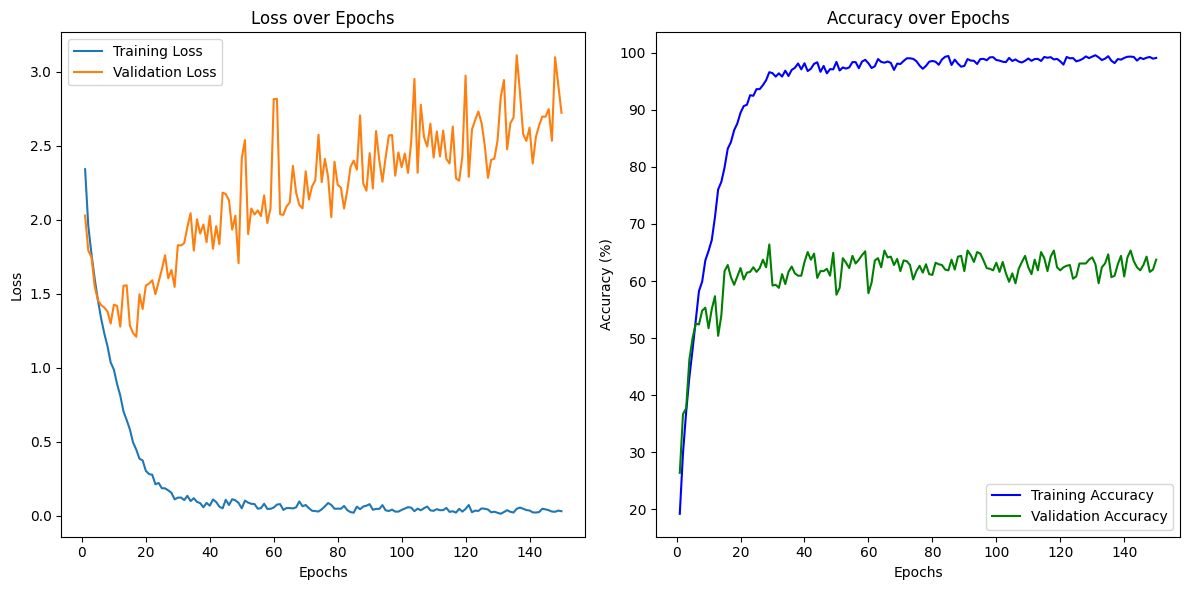

In [ ]:
## Select your best model with respect to validation accuracy
## Visualize the accuracy and loss change of the best performing model across training and validation datasets.

import matplotlib.pyplot as plt

def plot_metrics(train_losses, val_losses, val_accuracies, train_accuracies, num_epochs):
    epochs = range(1, num_epochs + 1)

    # Plotting Training and Validation Loss
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Training Loss')
    plt.plot(epochs, val_losses, label='Validation Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plotting Validation Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label='Training Accuracy', color='blue')
    plt.plot(epochs, val_accuracies, label='Validation Accuracy', color='green')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    plt.tight_layout()
    plt.show()


# Visualize the results
plot_metrics(train_losses, val_losses, val_accuracies, train_accuracies, num_epochs=best_epochs)


**Left Plot: Loss over Time**

*The training loss* steadily decreases and approaches zero, which means the model is learning the patterns in the training data very well.

*The validation loss* decreases initially but starts fluctuating as training progresses.
Later on, it even increases slightly, which suggests that the model is starting to overfit, meaning it’s focusing too much on the training data and not generalizing well to new, unseen data.

**Right Plot: Accuracy over Time**

*The training accuracy* increases rapidly and gets close to 100%, showing that the model performs extremely well on the training dataset.

*The validation accuracy* improves in the early epochs but then stabilizes around 60-65%, with some fluctuations.

This indicates that while the model has learned to recognize patterns in the data, it struggles to generalize beyond the training set.

### 1.6 Evaluate the trained model on the test set (6 points)

<ipython-input-12-776200320065>:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("final_model.pth"))


Test Accuracy: 60.27%

Classification Report:
              precision    recall  f1-score   support

        cane       0.36      0.49      0.42        74
     cavallo       0.79      0.55      0.65        80
    elefante       0.67      0.72      0.70        86
    farfalla       0.75      0.73      0.74        66
     gallina       0.79      0.50      0.61        74
       gatto       0.61      0.42      0.50        73
       mucca       0.64      0.63      0.63        70
      pecora       0.53      0.71      0.60        82
       ragno       0.57      0.78      0.66        68
  scoiattolo       0.57      0.51      0.53        77

    accuracy                           0.60       750
   macro avg       0.63      0.60      0.60       750
weighted avg       0.63      0.60      0.60       750



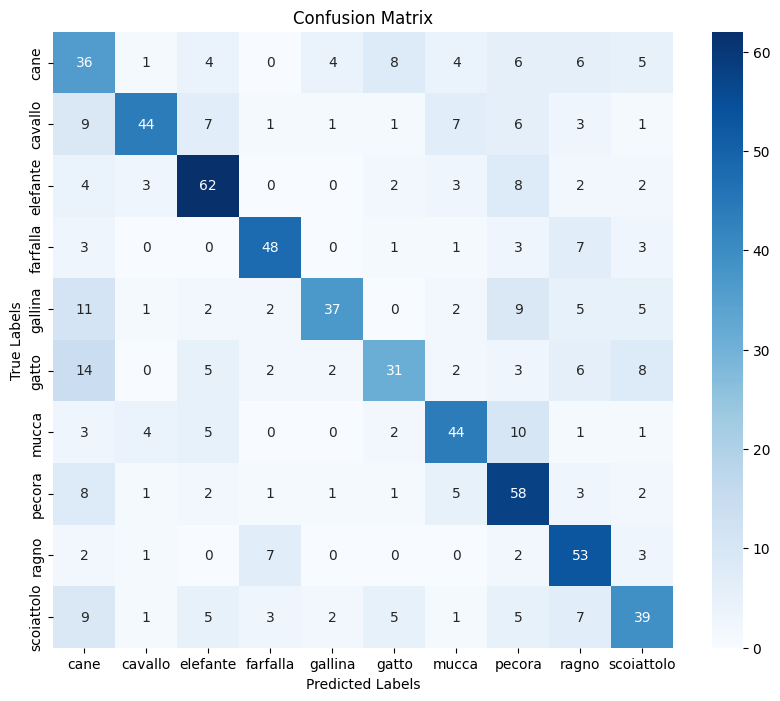

In [ ]:
## Test the trained model on the test set to evaluate its performance
## Compute metrics such as accuracy, precision, recall, and F1-score
## Visualize confusion matrix to understand the model's behavior across different classes
## Comment on the results



from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Load the saved model (update the path to your model file if needed)
model = create_cnn_model(num_classes=len(dataset.classes), input_size=input_size)
model.load_state_dict(torch.load("final_model.pth"))
model.to(device)
model.eval()

best_batch_size = 32
# Function to evaluate the model on the test set
def evaluate_model(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    accuracy = 100 * correct / total
    return accuracy, all_labels, all_preds

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=best_batch_size, shuffle=False)

# Evaluate the model
test_accuracy, test_labels, test_preds = evaluate_model(model, test_loader, device)
print(f"Test Accuracy: {test_accuracy:.2f}%")

# Compute classification report
print("\nClassification Report:")
print(classification_report(test_labels, test_preds, target_names=dataset.classes))

# Confusion Matrix Visualization
cm = confusion_matrix(test_labels, test_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=dataset.classes, yticklabels=dataset.classes)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()


### 1.7 Conclusion and interpretation (7 points)
* **Summarize the performance of the model on the test set**

The model achieved an overall test accuracy of 60.27%, as reflected in the classification report. While some classes, such as farfalla (butterfly) and elefante (elephant), performed well with F1-scores of 0.74 and 0.70, others like cane (dog) and gatto (cat) had lower F1-scores of 0.42 and 0.50, respectively. The average precision, recall, and F1-score across all classes are around 0.63, indicating that the model performs moderately well but struggles with certain classes.

The variation in performance across classes suggests that some categories are easier for the model to classify, possibly due to distinct features, while others may have overlapping features or less representative samples, leading to misclassifications.
For example, there are dogs which looks like a cat or a disabled dog (doesn't have front legs, instead of legs it has wheel legs.)
These kind of situations can decrease the accuracy.


* **Discuss any challenges encountered during training and potential areas for improvement**

During training, several challenges were encountered. One major issue was overfitting, as the training accuracy approached 100% while the validation accuracy plateaued around 65%, indicating that the model memorized the training data but struggled to generalize to unseen data. Another challenge was class imbalance, with some classes, like cane and gatto, performing significantly worse than others. This may have been due to variability in feature representation or overlapping and less distinctive features between these classes. Additionally, validation loss instability was observed in later epochs, with significant fluctuations suggesting that the model struggled to maintain consistency, possibly due to an inappropriate learning rate or architectural limitations. Lastly, the complexity of features in certain animal classes, such as the visual similarity between gatto and cane, made it harder for the CNN to effectively distinguish between them.


* **Reflect on the overall effectiveness of the chosen CNN architecture and training approach**

The CNN architecture did a good job of extracting features and performed reasonably well, achieving a test accuracy of over 60%. However, some challenges during training, like overfitting and unstable validation loss, suggest that the model might have been a bit too complex for the size of the dataset or that it needed stronger regularization techniques.

While the training process allowed the model to learn the patterns in the training data very effectively, it struggled to generalize to new, unseen data. By making some adjustments to the architecture, using more robust data augmentation, and incorporating better regularization methods, the model’s performance could likely improve further.

Overall, the CNN showed its potential for the task, but refining the architecture and training process will be essential to make it more robust and achieve higher accuracy and more consistent performance across all classes.

### 1.8 Kaggle Test Result (5 points)
* Put your Kaggle test result for your CNN model here and comment on it.
* You will get a score between 0-1 and your percentage (e.g. 0.1, 0.3, 0.6, 0.85) of accuracy will be multiplied by the highest possible score (5 points) for this part. That will be your grading score.

## 2. Exploring Transfer Learning with ResNet50 and MobileNet (60 points)

### 2.1. Introduction
* **Brief overview of the task.**

In this part of the assignment, the focus is on using transfer learning to classify images in the Animal-10 dataset by fine-tuning pre-trained models like ResNet-18 and MobileNet. Transfer learning takes advantage of models that have already been trained on massive datasets, like ImageNet, allowing us to reuse their learned features for a new task without starting from scratch. You'll experiment with different fine-tuning methods, such as adjusting only the last layer, updating specific parts of the model, or fine-tuning the entire model. Finally, you'll compare how these pre-trained models perform against the CNN you built from scratch, analyzing the pros and cons of each approach.

* **Answer the questions like, What is fine-tuning? Why should we do this? Why do we freeze the rest and train only last layers?**

**What is Fine-Tuning?**

Fine-tuning is the process of taking a pre-trained model and adapting it to a new, specific task by updating its weights. While the model has already learned generic features from its original training dataset (e.g., ImageNet), fine-tuning allows it to adjust those features to better fit the new dataset, such as Animal-10.

For example:

In the base model, only the weights of the final fully connected (FC) layer are fine-tuned to map the generic features to the specific classes in the Animal-10 dataset.

In deeper fine-tuning strategies, other layers or blocks of the model are updated to adapt the pre-trained features more effectively to the new task.

**Why Should We Do This?**

**Efficiency:** Fine-tuning saves a lot of time and computational resources because we don't need to train the model from scratch. Instead, we build on the knowledge the model has already acquired.

**Better Performance with Limited Data:** Pre-trained models have learned features from large datasets. Fine-tuning allows us to adapt these features to the new dataset, especially when the new dataset (e.g., Animal-10) has limited labeled data.

**Why Do We Freeze the Rest and Train Only the Last Layers?**

We freeze the earlier layers of a pre-trained model and train only the last layers for several reasons. First, the earlier layers are responsible for extracting basic features like edges and textures, which are universal across most image datasets. These features don’t need to be retrained, so freezing these layers ensures we preserve this valuable prior knowledge.

Another reason is to prevent overfitting. When working with a small dataset, like Animal-10, updating all the model’s weights can lead to overfitting and poor generalization. Training only the last layers helps the model adapt to the new task without losing its ability to generalize.

It’s also much more efficient. By freezing most of the layers, we significantly reduce the number of parameters being updated, which decreases training time and computational costs.

Lastly, the last layers of a pre-trained model are responsible for task-specific feature extraction. By fine-tuning these layers, we can tailor the model to the specific needs of the new dataset, like recognizing animals in Animal-10, while leveraging the strong foundation built by the earlier layers.



### 2.2. Load the pre-trained ResNet18 model (3 points)


In [ ]:
## Utilize torchvision library to load the pre-trained ResNet50 model
## Ensure that the model's architecture matches ResNet50, by checking the model summary.

import torch
import torch.nn as nn
import torchvision.models as models
from torchsummary import summary

# Load the pre-trained ResNet-18 model
resnet18 = models.resnet18(pretrained=True)
resnet18.to('cuda')

# Check the model architecture
print("ResNet-18 Architecture:")
summary(resnet18, input_size=(3, 224, 224))

# Number of classes in the Animal-10 dataset
num_classes = 10

# Modify the FC layer
resnet18.fc = nn.Linear(resnet18.fc.in_features, num_classes)
resnet18.to('cuda')

# Verify the updated architecture
print("\nModified ResNet-18 Architecture:")
summary(resnet18, input_size=(3, 224, 224))



/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 217MB/s]


ResNet-18 Architecture:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             Re

### 2.3 Modify the ResNet18 model for transfer learning (15 points)

### **What I made below:**
**Freezing Pre-trained Layers:** All the layers of the ResNet18 model, except the last fully connected (FC) layer, are frozen. This means the pre-trained features, like detecting edges and textures, are kept as they are and won't be updated during training.

**Unfreezing the Last Layer:** The final FC layer, which maps the features to the Animal-10 classes, is unfrozen. This layer is replaced with a new one to match the number of classes in the Animal-10 dataset, and it is trained to adapt the pre-trained features for this specific task.

**Loss Function and Optimizer:**

The loss function is cross-entropy loss, commonly used for multi-class classification tasks.
The Adam optimizer is used to update only the weights of the new FC layer with a learning rate of 0.001.
Data Loaders: The training and validation datasets are prepared with a batch size of 32 to feed data into the model during training and evaluation.

**Training:** The model is trained for 150 epochs. During this time, only the new FC layer is updated while the rest of the model remains unchanged. Training and validation losses and accuracies are tracked to monitor performance.

**Saving the Model:** After training, the model’s weights are saved in a file called "resnet18_base_model.pth", so it can be reused later without retraining.

In [ ]:
## Freeze all layers of the ResNet18 model.
## Replace the final fully connected layer with a new FC layer matching the number of classes
## Unfreeze the final FC layer
## Define appropriate loss function and optimizer for training
## Train the modified ResNet18 model on the animal-10 image dataset. (base model)
# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer for the final FC layer (base model)
optimizer_resnet18 = torch.optim.Adam(resnet18.fc.parameters(), lr=0.001)
#optimizer_resnet50 = torch.optim.Adam(resnet50.fc.parameters(), lr=0.001)

# Freeze all layers except the final FC layer
for param in resnet18.parameters():
    param.requires_grad = False

for param in resnet18.fc.parameters():
    param.requires_grad = True

train_loader_18 = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader_18 = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False)

train_losses_18, val_losses_18, val_accuracies_18, train_accuracies_18 = train_and_validate(resnet18, train_loader_18, val_loader_18, criterion, optimizer_resnet18, num_epochs=150, device='cuda')

model_save_path = "resnet18_base_model.pth"

# Save the state dictionary of the trained model
torch.save(resnet18.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")



Epoch [1/150]: Train Loss: 1.0190, Val Loss: 0.4129, Val Accuracy: 91.33%
Epoch [2/150]: Train Loss: 0.3647, Val Loss: 0.2901, Val Accuracy: 92.53%
Epoch [3/150]: Train Loss: 0.2611, Val Loss: 0.2307, Val Accuracy: 94.27%
Epoch [4/150]: Train Loss: 0.2201, Val Loss: 0.2083, Val Accuracy: 94.93%
Epoch [5/150]: Train Loss: 0.1946, Val Loss: 0.2037, Val Accuracy: 94.13%
Epoch [6/150]: Train Loss: 0.1792, Val Loss: 0.1827, Val Accuracy: 94.40%
Epoch [7/150]: Train Loss: 0.1515, Val Loss: 0.1764, Val Accuracy: 94.53%
Epoch [8/150]: Train Loss: 0.1525, Val Loss: 0.1736, Val Accuracy: 94.80%
Epoch [9/150]: Train Loss: 0.1356, Val Loss: 0.1658, Val Accuracy: 95.20%
Epoch [10/150]: Train Loss: 0.1345, Val Loss: 0.1758, Val Accuracy: 94.53%
Epoch [11/150]: Train Loss: 0.1205, Val Loss: 0.1664, Val Accuracy: 94.80%
Epoch [12/150]: Train Loss: 0.1128, Val Loss: 0.1567, Val Accuracy: 95.87%
Epoch [13/150]: Train Loss: 0.1078, Val Loss: 0.1665, Val Accuracy: 95.33%
Epoch [14/150]: Train Loss: 0.1018

The highest validation accuracy above is 95.87%.

### **What I made below:**

**Loading a Fresh ResNet18 Model:** A new ResNet18 model pre-trained on ImageNet is loaded, and its final FC layer is replaced with one that matches the 10 classes in the Animal-10 dataset.

**Freezing Layers:** All layers in the model are initially frozen, meaning their weights won’t be updated during training.

**Unfreezing Specific Layers:** Layers in block 3, block 4, and the final FC layer are unfrozen. This allows these parts of the model to be updated and fine-tuned for the Animal-10 dataset while keeping the rest of the model’s pre-trained knowledge intact.

**Loss Function and Optimizer:**

**Loss Function:** Cross-entropy loss is used to measure the difference between the model’s predictions and the actual labels.
**Optimizer:** Adam optimizer is applied to update only the weights of the unfrozen layers.
**Training:** The model is trained for 150 epochs using the same training and validation datasets as before. Only the unfrozen layers are updated during training.

**Saving the Model:** After training, the model’s weights are saved to a file named "resnet18_second_model.pth", so it can be reused later without retraining.

**Purpose:**
This approach fine-tunes specific parts of the ResNet18 model (blocks 3, 4, and FC layer) to better adapt the pre-trained features for the Animal-10 dataset, while still leveraging the general features learned from ImageNet.

In [ ]:
## Define another ResNet18 model
## Freeze all layers of the ResNet18 model.
## Replace the final fully connected layer with a new FC layer matching the number of classes
## Unfreeze the final FC layer
## Unfreeze convolutional layers 3 and 4 of the ResNet18 model and again proceed with training. (second model)

# Load a fresh ResNet-18 model
resnet18_second_model = models.resnet18(pretrained=True)
resnet18_second_model.fc = nn.Linear(resnet18_second_model.fc.in_features, 10)  # Modify FC layer for Animal-10
resnet18_second_model.to('cuda')

# Freeze all layers
for param in resnet18_second_model.parameters():
    param.requires_grad = False

# Unfreeze layers in block 3, block 4, and the FC layer
for name, param in resnet18_second_model.named_parameters():
    if "layer3" in name or "layer4" in name or "fc" in name:
        param.requires_grad = True

# Define loss function and optimizer
criterion_second = nn.CrossEntropyLoss()
optimizer_second = torch.optim.Adam(filter(lambda p: p.requires_grad, resnet18_second_model.parameters()), lr=0.001)

# Data loaders (same batch size as before)
train_loader_second = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader_second = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False)

# Train the second model
train_losses_second, val_losses_second, val_accuracies_second, train_accuracies_second = train_and_validate(
    resnet18_second_model, train_loader_second, val_loader_second, criterion_second, optimizer_second, num_epochs=150, device='cuda'
)

# Save the trained second model
model_save_path_second = "resnet18_second_model.pth"
torch.save(resnet18_second_model.state_dict(), model_save_path_second)
print(f"Second model saved to {model_save_path_second}")



Epoch [1/150]: Train Loss: 0.7264, Val Loss: 0.8535, Val Accuracy: 78.53%
Epoch [2/150]: Train Loss: 0.3087, Val Loss: 0.4571, Val Accuracy: 86.40%
Epoch [3/150]: Train Loss: 0.1427, Val Loss: 0.5143, Val Accuracy: 85.33%
Epoch [4/150]: Train Loss: 0.1286, Val Loss: 0.5846, Val Accuracy: 84.00%
Epoch [5/150]: Train Loss: 0.1107, Val Loss: 0.5485, Val Accuracy: 85.20%
Epoch [6/150]: Train Loss: 0.0923, Val Loss: 0.6096, Val Accuracy: 84.27%
Epoch [7/150]: Train Loss: 0.0653, Val Loss: 0.4602, Val Accuracy: 88.13%
Epoch [8/150]: Train Loss: 0.0649, Val Loss: 0.5156, Val Accuracy: 86.40%
Epoch [9/150]: Train Loss: 0.0356, Val Loss: 0.5004, Val Accuracy: 86.80%
Epoch [10/150]: Train Loss: 0.0674, Val Loss: 0.5019, Val Accuracy: 86.40%
Epoch [11/150]: Train Loss: 0.0708, Val Loss: 0.5084, Val Accuracy: 87.33%
Epoch [12/150]: Train Loss: 0.0391, Val Loss: 0.5121, Val Accuracy: 86.27%
Epoch [13/150]: Train Loss: 0.0432, Val Loss: 0.4581, Val Accuracy: 89.87%
Epoch [14/150]: Train Loss: 0.0383

The highest validation accuracy above is 91.87%

### **What I did below:**
**Loading a Pre-trained ResNet18 Model:**
A ResNet18 model pre-trained on ImageNet is loaded, and its final fully connected (FC) layer is replaced with one tailored for the 10 classes in the Animal-10 dataset.

**Unfreezing All Layers:** Unlike the previous approaches, here all layers in the model are trainable. This means the weights of the entire model, including earlier layers, will be updated during training.

**Loss Function and Optimizer:**

**Loss Function:** Cross-entropy loss is used to calculate the error between the model's predictions and the actual class labels.

**Optimizer:** Adam optimizer with a smaller learning rate (0.0001) is used, as fine-tuning all layers requires slower updates to ensure stable training.

**Data Loaders:** Data loaders for training and validation datasets are created with a batch size of 32 to feed the data into the model during training and evaluation.

**Training:** The model is trained for 150 epochs using the train_and_validate function. During this process:

The loss is calculated, and the model weights are updated for all layers.
Validation performance is monitored periodically to evaluate how well the model generalizes to unseen data.

**Saving the Model:** Once training is complete, the model's weights are saved in a file named "resnet18_third_model.pth" for later use.

**Purpose:**
This approach fine-tunes the entire ResNet18 model, allowing it to adapt all of its layers to the Animal-10 dataset. By doing this, the model has more flexibility to learn features specific to the dataset, which may result in better performance but requires careful training to avoid overfitting.

In [ ]:
## Define another ResNet18 model
## Replace the final fully connected layer with a new FC layer matching the number of classes proceed with training. (third model)
resnet18_third_model = models.resnet18(pretrained=True)
resnet18_third_model.fc = nn.Linear(resnet18_third_model.fc.in_features, 10)  # Modify FC layer for Animal-10
resnet18_third_model.to('cuda')

# Unfreeze all layers (default is all layers are trainable)
for param in resnet18_third_model.parameters():
    param.requires_grad = True



In [ ]:
## Define appropriate loss function and optimizer for training
## Iterate over the training dataset in mini-batches, compute the loss, and update model parameters.
## Monitor the training process and evaluate all model's performance on the validation set periodically.
## Visualize the accuracy and loss changes of the models across training and validation datasets.

# Define loss function and optimizer
criterion_third = nn.CrossEntropyLoss()
optimizer_third = torch.optim.Adam(resnet18_third_model.parameters(), lr=0.0001)  # Smaller learning rate for full fine-tuning

# Data loaders (same batch size as before)
train_loader_third = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader_third = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False)

# Train the third model
train_losses_third, val_losses_third, val_accuracies_third, train_accuracies_third = train_and_validate(
    resnet18_third_model, train_loader_third, val_loader_third, criterion_third, optimizer_third, num_epochs=150, device='cuda'
)

# Save the trained third model
model_save_path_third = "resnet18_third_model.pth"
torch.save(resnet18_third_model.state_dict(), model_save_path_third)
print(f"Third model saved to {model_save_path_third}")


Epoch [1/150]: Train Loss: 0.5822, Val Loss: 0.2450, Val Accuracy: 93.20%
Epoch [2/150]: Train Loss: 0.0860, Val Loss: 0.2102, Val Accuracy: 94.53%
Epoch [3/150]: Train Loss: 0.0249, Val Loss: 0.1714, Val Accuracy: 95.60%
Epoch [4/150]: Train Loss: 0.0125, Val Loss: 0.1665, Val Accuracy: 95.47%
Epoch [5/150]: Train Loss: 0.0072, Val Loss: 0.1719, Val Accuracy: 95.87%
Epoch [6/150]: Train Loss: 0.0056, Val Loss: 0.1689, Val Accuracy: 95.73%
Epoch [7/150]: Train Loss: 0.0037, Val Loss: 0.1725, Val Accuracy: 95.47%
Epoch [8/150]: Train Loss: 0.0029, Val Loss: 0.1812, Val Accuracy: 95.60%
Epoch [9/150]: Train Loss: 0.0026, Val Loss: 0.1812, Val Accuracy: 95.33%
Epoch [10/150]: Train Loss: 0.0023, Val Loss: 0.1790, Val Accuracy: 95.60%
Epoch [11/150]: Train Loss: 0.0022, Val Loss: 0.1751, Val Accuracy: 95.47%
Epoch [12/150]: Train Loss: 0.0019, Val Loss: 0.1797, Val Accuracy: 95.60%
Epoch [13/150]: Train Loss: 0.0015, Val Loss: 0.1750, Val Accuracy: 95.60%
Epoch [14/150]: Train Loss: 0.0013

The highest validation accuracy above is 96.00%.

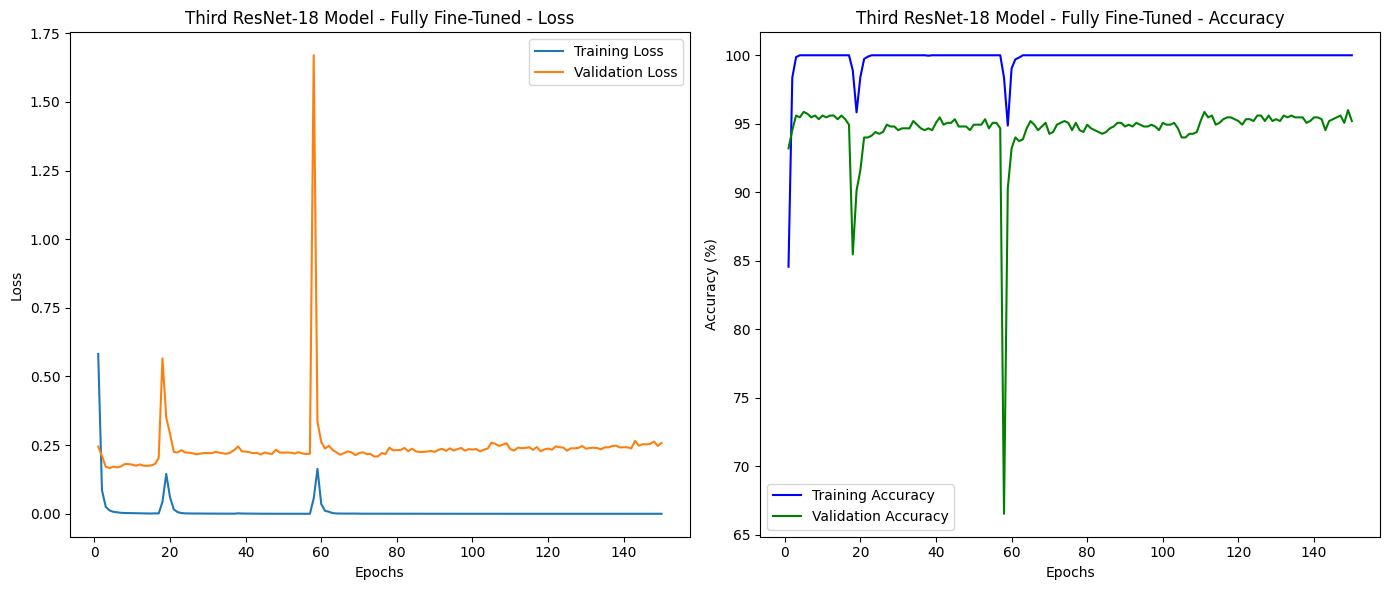

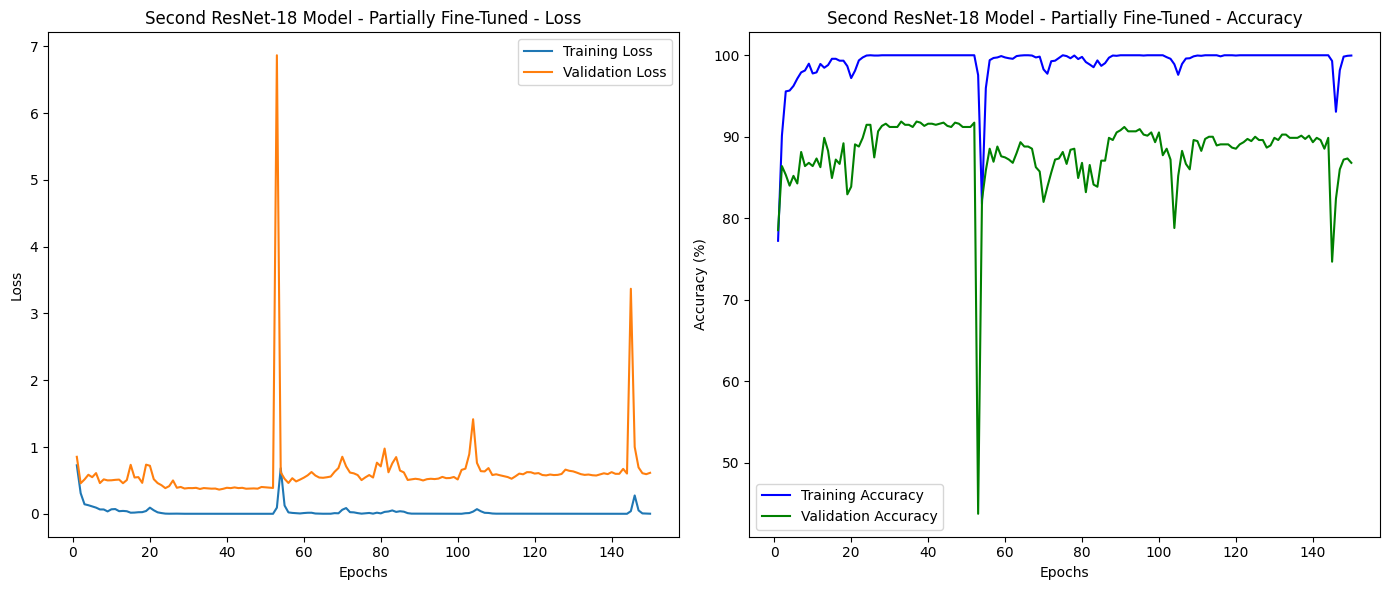

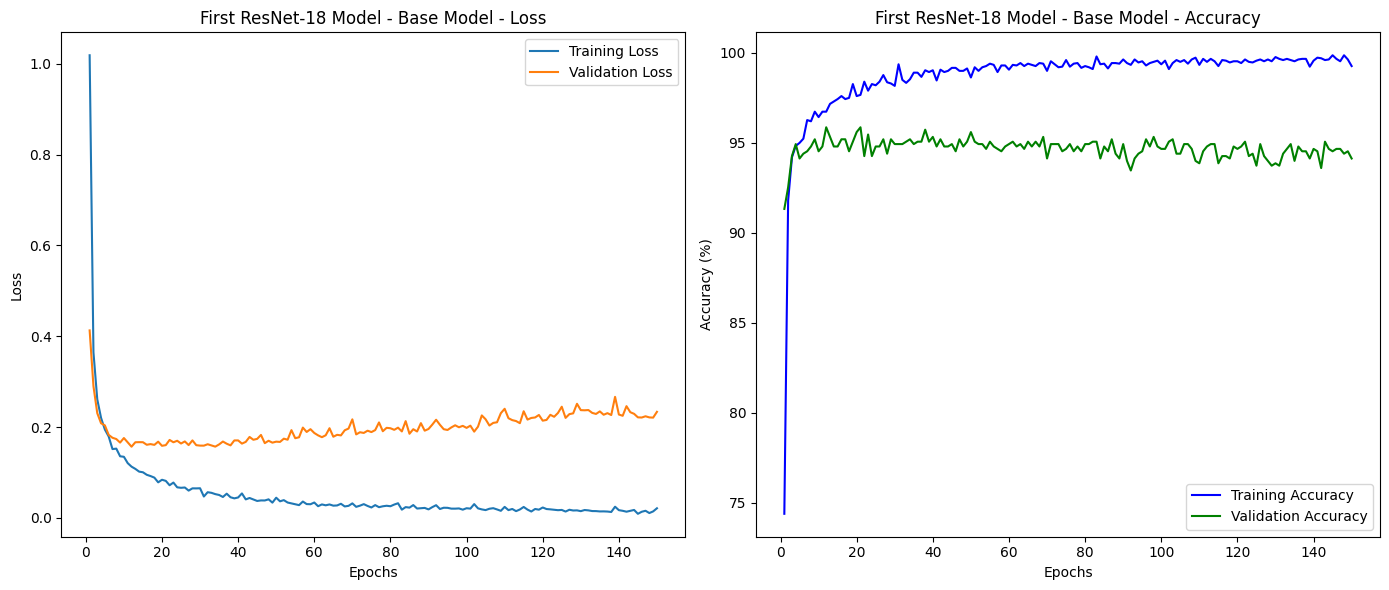

In [ ]:
def plot_metrics(train_losses, val_losses, val_accuracies, train_accuracies, num_epochs, title):
    epochs = range(1, num_epochs + 1)

    # Plot Loss
    plt.figure(figsize=(14, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label="Training Loss")
    plt.plot(epochs, val_losses, label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title(f"{title} - Loss")
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label="Training Accuracy", color="blue")
    plt.plot(epochs, val_accuracies, label="Validation Accuracy", color="green")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy (%)")
    plt.title(f"{title} - Accuracy")
    plt.legend()

    plt.tight_layout()
    plt.show()


# Visualize the third model's training metrics
plot_metrics(
    train_losses_third, val_losses_third, val_accuracies_third, train_accuracies_third, num_epochs=150,
    title="Third ResNet-18 Model - Fully Fine-Tuned"
)

plot_metrics(
    train_losses_second, val_losses_second, val_accuracies_second, train_accuracies_second, num_epochs=150,
    title="Second ResNet-18 Model - Partially Fine-Tuned"
)

plot_metrics(
    train_losses_18, val_losses_18, val_accuracies_18, train_accuracies_18, num_epochs=150,
    title="First ResNet-18 Model - Base Model"
)


Conduct a comparative analysis among these three models. Comment on their performance and select your best model with respect to validation accuracy.

**First Model:**

**Highest Validation Accuracy:** 95.87%

**Training Strategy:** Fine-tuned only the final fully connected (FC) layer, freezing all other layers in the ResNet-18 model.

**Performance Summary:** This model achieved a high validation accuracy by leveraging the pre-trained features of ResNet-18 while making minimal updates. It demonstrated strong generalization due to minimal weight updates and the ability to transfer low-level and mid-level features effectively.

**Second Model:**

**Highest Validation Accuracy:** 91.87%

**Training Strategy:** Fine-tuned the FC layer along with the last two convolutional blocks (layer3 and layer4). Earlier layers remained frozen.

**Performance Summary:** This model showed slightly lower validation accuracy compared to the first model, likely because it attempted to adjust a larger portion of the network's weights. This increased the model's flexibility but also introduced more complexity, which may have led to some overfitting or inefficiencies due to the relatively small dataset size.

**Third Model:**

**Highest Validation Accuracy:** 96.00%

**Training Strategy:** Fine-tuned all layers in the ResNet-18 model, allowing complete retraining of the network.

**Performance Summary:** The third model slightly outperformed the first, achieving the highest validation accuracy. Full fine-tuning allowed the model to adapt deeply to the Animal-10 dataset, utilizing the pre-trained features while recalibrating the entire network to fit the specific task. The success of this approach reflects the model's ability to utilize additional flexibility without significant overfitting.

### * **Which model performed better and why do you think it performed better?**  

The third model is the best-performing model with respect to validation accuracy (96.00%). Its ability to fine-tune all layers allowed it to achieve better task-specific adaptation, leading to improved performance.

**Why the Third Model Performed Better**

**Greater Flexibility:** The third model fine-tuned all layers, enabling it to recalibrate the pre-trained features fully to the specific characteristics of the Animal-10 dataset. This flexibility allowed it to make better use of the dataset's unique features.

**Sufficient Dataset Size:** While not a very large dataset, Animal-10 provided enough labeled data to benefit from full fine-tuning without significant overfitting.

###* **Comment on the practical considerations among these models also.**


*   The first model required less computational effort and training time since only the FC layer was updated.
*   The second model needed more resources as it involved updating two additional convolutional blocks.
*   The third model was the most resource-intensive due to the full network fine-tuning.

*   The first model was least prone to overfitting since most weights were frozen.
*   The second model introduced more trainable parameters, slightly increasing the risk of overfitting.
*   The third model, while most prone to overfitting, managed to generalize well due to appropriate hyperparameters and a relatively diverse dataset.
Ease of Implementation:

*   The first model was easiest to implement as only the FC layer required modification and optimization.
*   The second and third models required more careful layer unfreezing and optimization strategies.

### 2.4 Evaluate the fine-tuned ResNet18 model (5 points)

In [ ]:
## Test the best model on the test set to evaluate its performance.
## Compute metrics such as accuracy, precision, recall, and F1-score to assess classification performance.
## Visualize confusion matrix to understand the model's behavior across different classes
## Comment on the results
## Compare the fine-tuned ResNet18 model performance with the CNN model implemented from scratch

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

resnet18_best = models.resnet18(pretrained=False)
resnet18_best.fc = nn.Linear(resnet18_best.fc.in_features, 10)  # Match the number of classes
resnet18_best.to('cuda')

# Load the saved weights
resnet18_best.load_state_dict(torch.load("resnet18_third_model.pth"))
resnet18_best.eval()  # Set to evaluation mode

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
<ipython-input-25-8d6d28458fd2>:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the function

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Evaluate the model
def evaluate_model(model, test_loader, device='cuda'):
    model.to(device)
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return np.array(all_preds), np.array(all_labels)

# Get predictions and true labels
predictions, true_labels = evaluate_model(resnet18_best, test_loader)

# Compute classification report
report = classification_report(true_labels, predictions, target_names=dataset.classes)
print("Classification Report:")
print(report)


Classification Report:
              precision    recall  f1-score   support

        cane       0.86      0.92      0.89        74
     cavallo       0.95      0.93      0.94        80
    elefante       0.98      0.97      0.97        86
    farfalla       0.95      0.94      0.95        66
     gallina       0.96      0.95      0.95        74
       gatto       0.93      0.86      0.89        73
       mucca       0.93      0.94      0.94        70
      pecora       0.92      0.93      0.92        82
       ragno       0.96      0.97      0.96        68
  scoiattolo       0.92      0.95      0.94        77

    accuracy                           0.93       750
   macro avg       0.94      0.93      0.93       750
weighted avg       0.94      0.93      0.93       750



### Comparison of the CNN Model Implemented from Scratch and Fine-Tuned ResNet-18 Model

**Accuracy:**

**CNN Model:** The overall accuracy achieved was 60%, with a macro and weighted average F1-score of 0.60. Individual class performance was inconsistent, with certain classes like "cane" and "gatto" significantly underperforming.

**ResNet-18 Fine-Tuned Model:** Achieved an impressive overall accuracy of 93%, with macro and weighted average F1-scores of 0.93. It demonstrated consistently high performance across all classes, with most F1-scores exceeding 0.90.

**Training Efficiency:**

**CNN Model:** Training the CNN from scratch required significant computational resources and time due to the need to learn features from scratch. However, the model struggled to converge effectively, resulting in lower accuracy.

**ResNet-18 Fine-Tuned Model:** The fine-tuned ResNet-18 benefited from pre-trained weights, which drastically reduced the training time for feature extraction. The model achieved high performance with fewer training epochs compared to the CNN model.

**Resource Usage:**

**CNN Model:** Required high computational effort to train all layers from scratch. Despite this effort, the results were suboptimal, indicating inefficiencies in feature learning.

**ResNet-18 Fine-Tuned Model:** Leveraged pre-trained weights and only fine-tuned specific layers (depending on the fine-tuning strategy). This approach minimized computational cost and training time while achieving superior performance. The pre-trained model efficiently utilized resources to adapt to the Animal-10 dataset.

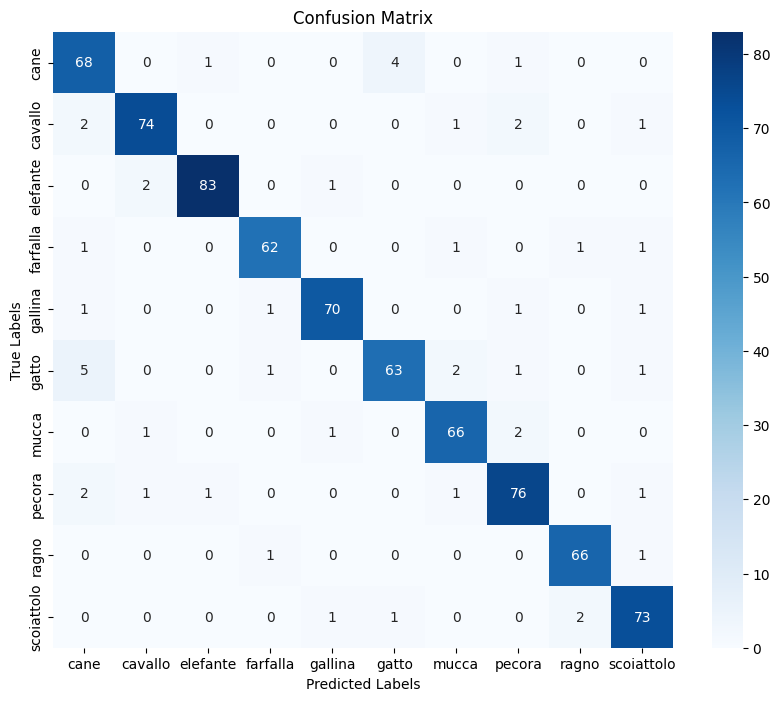

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

# Compute confusion matrix
conf_matrix = confusion_matrix(true_labels, predictions)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=dataset.classes, yticklabels=dataset.classes)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()


### 2.5 Kaggle Test Result (5 points)
* Put your Kaggle test result for your ResNet-18 pretrained model here and comment on it.
* You will get a score between 0-1 and your percentage (e.g. 0.1, 0.3, 0.6, 0.85) of accuracy will be multiplied by the highest possible score (5 points) for this part. That will be your grading score.

### 2.7. Load the pre-trained MobileNet model (3 points)


In [ ]:
## Utilize torchvision library to load the pre-trained MobileNetV2 model
## Ensure that the model's architecture matches MobileNetV2, by checking the model summary.
import torch
import torch.nn as nn
import torchvision.models as models
from torchsummary import summary

# Load the pre-trained MobileNetV2 model
mobilenetv2 = models.mobilenet_v2(pretrained=True)
mobilenetv2.to('cuda')

# Check the model architecture
print("MobileNetV2 Architecture:")
summary(mobilenetv2, input_size=(3, 224, 224))

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 224MB/s]


MobileNetV2 Architecture:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
             ReLU6-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]             288
       BatchNorm2d-5         [-1, 32, 112, 112]              64
             ReLU6-6         [-1, 32, 112, 112]               0
            Conv2d-7         [-1, 16, 112, 112]             512
       BatchNorm2d-8         [-1, 16, 112, 112]              32
  InvertedResidual-9         [-1, 16, 112, 112]               0
           Conv2d-10         [-1, 96, 112, 112]           1,536
      BatchNorm2d-11         [-1, 96, 112, 112]             192
            ReLU6-12         [-1, 96, 112, 112]               0
           Conv2d-13           [-1, 96, 56, 56]             864
      BatchNo

### 2.8 Modify the MobileNet model for transfer learning (10 points)

**Replaced the Final Layer:**

I replaced the original fully connected (FC) layer with a new one that matches the 10 classes in the Animal-10 dataset.

**Froze Most Layers:**

I froze all the layers of the model so their parameters wouldn't be updated during training.
I only unfroze the new FC layer to train it on the Animal-10 dataset.

**Defined the Loss Function:**

I used the CrossEntropyLoss function to calculate the error between the model’s predictions and the true labels.

**Set Up the Optimizer:**

I created an Adam optimizer to update the weights of only the new FC layer.

**Prepared Data Loaders:**

I used DataLoader to load the training and validation datasets in batches for efficient processing.

**Trained the Model:**

I trained the model for 150 epochs. During training, I monitored the training loss, validation loss, and validation accuracy to track progress.

**Saved the Trained Model:**

Finally, I saved the trained model’s weights to a .pth file so I can reuse it later.

In [ ]:
## Freeze all layers of the MobileNet model.
## Replace the final fully connected layer with a new FC layer matching the number of classes
## Unfreeze the final FC layer
## Define appropriate loss function and optimizer for training
## Train the modified MobileNet model on the animal-10 image dataset. (base model)

# Replace the final fully connected layer

num_classes = 10  # Number of classes in Animal-10 dataset
mobilenetv2.classifier[1] = nn.Linear(mobilenetv2.last_channel, num_classes)
mobilenetv2.to('cuda')

# Freeze all layers except the final FC layer
for param in mobilenetv2.parameters():
    param.requires_grad = False

for param in mobilenetv2.classifier.parameters():
    param.requires_grad = True


# Define loss function
criterion_mobilenet = nn.CrossEntropyLoss()

# Define optimizer (only for the FC layer)
optimizer_mobilenet = torch.optim.Adam(mobilenetv2.classifier.parameters(), lr=0.001)

# Data loaders
train_loader_mobilenet = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader_mobilenet = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False)

# Train the MobileNetV2 base model
train_losses_mobilenet, val_losses_mobilenet, val_accuracies_mobilenet, train_accuracies_mobilenet = train_and_validate(
    mobilenetv2, train_loader_mobilenet, val_loader_mobilenet, criterion_mobilenet, optimizer_mobilenet, num_epochs=150, device='cuda'
)

# Save the MobileNetV2 model
mobilenet_save_path = "mobilenetv2_base_model.pth"
torch.save(mobilenetv2.state_dict(), mobilenet_save_path)
print(f"MobileNetV2 model saved to {mobilenet_save_path}")



Epoch [1/150]: Train Loss: 0.8276, Val Loss: 0.3256, Val Accuracy: 92.27%
Epoch [2/150]: Train Loss: 0.2928, Val Loss: 0.2419, Val Accuracy: 93.60%
Epoch [3/150]: Train Loss: 0.2352, Val Loss: 0.2192, Val Accuracy: 94.40%
Epoch [4/150]: Train Loss: 0.1957, Val Loss: 0.1896, Val Accuracy: 95.33%
Epoch [5/150]: Train Loss: 0.1674, Val Loss: 0.1836, Val Accuracy: 94.93%
Epoch [6/150]: Train Loss: 0.1528, Val Loss: 0.1861, Val Accuracy: 94.40%
Epoch [7/150]: Train Loss: 0.1395, Val Loss: 0.1761, Val Accuracy: 94.93%
Epoch [8/150]: Train Loss: 0.1257, Val Loss: 0.1898, Val Accuracy: 94.13%
Epoch [9/150]: Train Loss: 0.1253, Val Loss: 0.1819, Val Accuracy: 93.73%
Epoch [10/150]: Train Loss: 0.1168, Val Loss: 0.1749, Val Accuracy: 94.67%
Epoch [11/150]: Train Loss: 0.1139, Val Loss: 0.1741, Val Accuracy: 94.53%
Epoch [12/150]: Train Loss: 0.1026, Val Loss: 0.1733, Val Accuracy: 94.53%
Epoch [13/150]: Train Loss: 0.0946, Val Loss: 0.1762, Val Accuracy: 94.80%
Epoch [14/150]: Train Loss: 0.0950

The highest validation accuracy is 95.47%.

In [ ]:
## Define another MobileNet model
## Replace the final fully connected layer with a new FC layer matching the number of classes proceed with training. (second model)

# Load a fresh MobileNetV2 model
mobilenetv2_second = models.mobilenet_v2(pretrained=True)
mobilenetv2_second.classifier[1] = nn.Linear(mobilenetv2_second.last_channel, 10)  # Update FC layer
mobilenetv2_second.to('cuda')

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

**Loaded a Fresh Model:** I started with a pre-trained MobileNetV2 model and replaced its final fully connected (FC) layer to match the number of classes in the dataset (10 classes).

**Unfroze All Layers:** I allowed all the layers in the model to be trainable so that the entire model could be fine-tuned during training.

**Defined Loss Function and Optimizer:** I used the cross-entropy loss function to evaluate the model's performance and the Adam optimizer with a learning rate of 0.0001 to update the weights of all layers.

**Prepared Data Loaders:** I used data loaders to feed the training and validation datasets into the model in mini-batches.

**Trained the Model:** I trained the model for 150 epochs, monitoring the training and validation loss and accuracy at each epoch.

**Saved the Model:** After training, I saved the trained model's parameters to a file named mobilenetv2_second_model.pth.

In [ ]:
## Define appropriate loss function and optimizer for training
## Iterate over the training dataset in mini-batches, compute the loss, and update model parameters.
## Monitor the training process and evaluate all model's performance on the validation set periodically.
## Visualize the accuracy and loss changes of the models across training and validation datasets.

for param in mobilenetv2_second.parameters():
    param.requires_grad = True

criterion_mobilenet_second = nn.CrossEntropyLoss()
# Optimizer for the entire model (since all layers are unfrozen)
optimizer_mobilenet_second = torch.optim.Adam(mobilenetv2_second.parameters(), lr=0.0001)

# Data loaders
train_loader_second = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader_second = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False)

# Train the second MobileNetV2 model
train_losses_second, val_losses_second, val_accuracies_second, train_accuracies_second = train_and_validate(
    mobilenetv2_second, train_loader_second, val_loader_second, criterion_mobilenet_second, optimizer_mobilenet_second, num_epochs=150, device='cuda'
)

# Save the second MobileNetV2 model
mobilenet_save_path_second = "mobilenetv2_second_model.pth"
torch.save(mobilenetv2_second.state_dict(), mobilenet_save_path_second)
print(f"Second MobileNetV2 model saved to {mobilenet_save_path_second}")




Epoch [1/150]: Train Loss: 0.7527, Val Loss: 0.2485, Val Accuracy: 94.13%
Epoch [2/150]: Train Loss: 0.1776, Val Loss: 0.1765, Val Accuracy: 95.20%
Epoch [3/150]: Train Loss: 0.0602, Val Loss: 0.1783, Val Accuracy: 94.67%
Epoch [4/150]: Train Loss: 0.0233, Val Loss: 0.1471, Val Accuracy: 96.13%
Epoch [5/150]: Train Loss: 0.0190, Val Loss: 0.1583, Val Accuracy: 95.60%
Epoch [6/150]: Train Loss: 0.0104, Val Loss: 0.1514, Val Accuracy: 96.00%
Epoch [7/150]: Train Loss: 0.0089, Val Loss: 0.1606, Val Accuracy: 95.73%
Epoch [8/150]: Train Loss: 0.0050, Val Loss: 0.1569, Val Accuracy: 96.27%
Epoch [9/150]: Train Loss: 0.0093, Val Loss: 0.1787, Val Accuracy: 95.20%
Epoch [10/150]: Train Loss: 0.0096, Val Loss: 0.1771, Val Accuracy: 95.60%
Epoch [11/150]: Train Loss: 0.0079, Val Loss: 0.1967, Val Accuracy: 95.07%
Epoch [12/150]: Train Loss: 0.0286, Val Loss: 0.1897, Val Accuracy: 94.80%
Epoch [13/150]: Train Loss: 0.0149, Val Loss: 0.2007, Val Accuracy: 95.07%
Epoch [14/150]: Train Loss: 0.0167

The highest validation accuracy is 96.40%.

Conduct a comparative analysis among these two models. Comment on their performance and select your best model with respect to validation accuracy.

**First Model (Base Model):**

**Highest Validation Accuracy:** 95.47%

**Layer Freezing:** All layers except the final fully connected (FC) layer were frozen.

**Performance:** Achieved good accuracy but slightly lower compared to the second model due to limited fine-tuning, which restricted the model's ability to adapt to the dataset.

**Second Model (Fully Fine-Tuned Model):**

**Highest Validation Accuracy:** 96.40%

**Layer Freezing:** No layers were frozen; the entire network was fine-tuned.

**Performance:** Achieved higher accuracy, likely due to its ability to update weights across all layers and better adapt to the specific features of the dataset.

* **Which model performed better and why do you think it performed better?**

The second model performed better, achieving a higher validation accuracy (96.40%) compared to the first model (95.47%). This can be attributed to the following:

Fine-tuning all layers allowed the model to learn deeper, dataset-specific representations, which is especially beneficial when working with a relatively small or specific dataset like Animal-10.

By updating weights across the entire network, the second model leveraged the pre-trained features more effectively.

* **Comment on the practical considerations among these models also.**

*   The first model required less training time and computational resources because only the FC layer was updated, while the rest of the layers remained frozen.
*   The second model was more computationally intensive due to fine-tuning all layers.

*   The first model had a lower risk of overfitting because most layers were frozen, reducing the number of trainable parameters.
*   The second model had a higher risk of overfitting due to the increased number of trainable parameters, but appropriate regularization and hyperparameters mitigated this risk.

*   The first model is more suitable for use cases where computational resources are limited or quick deployment is needed.
*   The second model is ideal for scenarios where achieving the best possible accuracy is critical, and sufficient resources are available for training.

### 2.9 Evaluate the fine-tuned MobileNet model (7 points)

In [ ]:
## Test the best model on the test set to evaluate its performance.
## Compute metrics such as accuracy, precision, recall, and F1-score to assess classification performance.
## Visualize confusion matrix to understand the model's behavior across different classes
## Comment on the results
# Load the best-performing model weights

from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Define the test loader
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

# Load the best model (Second MobileNetV2)
mobilenetv2_best = models.mobilenet_v2(pretrained=False)
mobilenetv2_best.classifier[1] = nn.Linear(mobilenetv2_best.last_channel, 10)  # Match the number of classes
mobilenetv2_best.to('cuda')

# Load the saved weights
mobilenetv2_best.load_state_dict(torch.load("mobilenetv2_second_model.pth"))
mobilenetv2_best.eval()  # Set to evaluation mode




/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
<ipython-input-33-8bb4625cd328>:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recomme

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [ ]:
# Evaluate the model
def evaluate_model(model, test_loader, device='cuda'):
    model.to(device)
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)  # Get the predicted class
            all_preds.extend(preds.cpu().numpy())  # Append predictions
            all_labels.extend(labels.cpu().numpy())  # Append true labels

    return np.array(all_preds), np.array(all_labels)

# Get predictions and true labels
predictions, true_labels = evaluate_model(mobilenetv2_best, test_loader)

# Compute and print classification report
report = classification_report(true_labels, predictions, target_names=dataset.classes)
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

        cane       0.82      0.91      0.86        74
     cavallo       0.94      0.85      0.89        80
    elefante       0.99      0.94      0.96        86
    farfalla       0.89      0.97      0.93        66
     gallina       0.97      0.89      0.93        74
       gatto       0.93      0.88      0.90        73
       mucca       0.85      0.96      0.90        70
      pecora       0.95      0.94      0.94        82
       ragno       0.92      0.96      0.94        68
  scoiattolo       0.96      0.92      0.94        77

    accuracy                           0.92       750
   macro avg       0.92      0.92      0.92       750
weighted avg       0.92      0.92      0.92       750



**Accuracy**
*   MobileNet achieved a significantly higher accuracy of 92%, while the CNN model implemented from scratch only reached 60%.
The classification report for MobileNet shows strong performance across all classes with high precision, recall, and F1-scores, indicating consistent predictions.
*   The CNN model struggled, as reflected in lower precision, recall, and F1-scores, particularly for certain classes like "cane" and "gatto," where the model's accuracy dropped considerably.

**Training Efficiency**
*   MobileNet required less training time per epoch because it leveraged pre-trained weights and was fine-tuned. This reduced the number of parameters requiring significant updates during training, especially for partially frozen layers in its first variant.
*   The CNN model had to learn from scratch, leading to longer training times and less efficient convergence due to its need to learn low-level features in addition to high-level features.

**Resource Usage**
*   MobileNet is optimized for efficiency and uses fewer computational resources while achieving high accuracy. Its architecture is designed to be lightweight, making it suitable for tasks with resource constraints.
*   The CNN model from scratch is less efficient, requiring more computational power and time to achieve results that are ultimately inferior to MobileNet.


Confusion Matrix:
[[67  0  0  0  1  2  2  1  1  0]
 [ 4 68  1  1  0  0  5  0  1  0]
 [ 0  0 81  0  1  0  3  1  0  0]
 [ 1  0  0 64  0  0  0  0  1  0]
 [ 0  1  0  3 66  0  1  1  1  1]
 [ 6  0  0  2  0 64  0  0  0  1]
 [ 0  2  0  0  0  0 67  1  0  0]
 [ 3  1  0  0  0  0  0 77  1  0]
 [ 0  0  0  2  0  0  0  0 65  1]
 [ 1  0  0  0  0  3  1  0  1 71]]


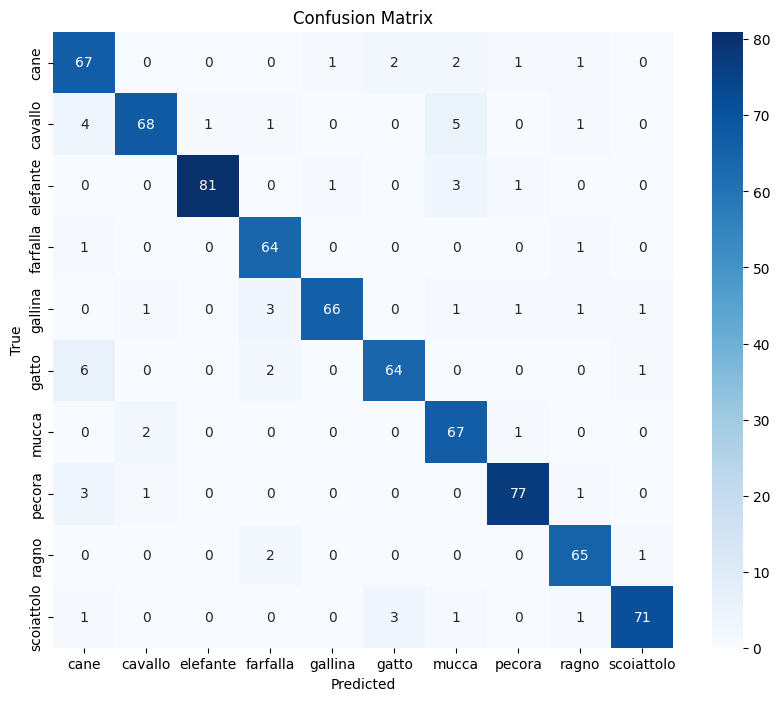

In [ ]:
# Compute and display confusion matrix
conf_matrix = confusion_matrix(true_labels, predictions)
print("\nConfusion Matrix:")
print(conf_matrix)

# Optional: Visualize confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=dataset.classes, yticklabels=dataset.classes)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [ ]:
## Compare the best fine-tuned MobileNet model performance with the best CNN model implemented from scratch
## Compare the best fine-tuned MobileNet model performance with the best ResNet18 model implemented from scratch

### MobileNet vs. CNN:

**Overall Accuracy:** MobileNet significantly outperforms CNN with an accuracy of 92% compared to 60%. This is a clear indication that MobileNet's pre-trained layers and transfer learning help achieve much better results.

**Class-Wise Performance:** MobileNet shows higher precision, recall, and F1-scores across almost all classes compared to CNN, demonstrating that it generalizes better to different categories.

**Practical Consideration:** CNN from scratch lacks the advantage of pre-learned features, leading to lower performance. MobileNet is more resource-efficient, thanks to transfer learning, but still achieves a high level of accuracy.

### MobileNet vs. ResNet18:

**Overall Accuracy:** ResNet18 has a slightly better accuracy of 93% compared to MobileNet's 92%. However, MobileNet's performance is very close.

**Class-Wise Performance:** ResNet18 edges out MobileNet in certain classes (e.g., "cane" and "ragno") with higher precision and F1-scores. However, MobileNet remains competitive and shows strong performance.

**Practical Consideration:** While both models leverage transfer learning, ResNet18 benefits from its deeper architecture and more sophisticated design, making it slightly more accurate. However, MobileNet might be preferred for deployment on resource-constrained devices due to its lighter architecture.

### 2.10 Kaggle Test Result (5 points)
* Put your Kaggle test result for your MobileNet pretrained model here and comment on it.
* You will get a score between 0-1 and your percentage (e.g. 0.1, 0.3, 0.6, 0.85) of accuracy will be multiplied by the highest possible score (5 points) for this part. That will be your grading score.

## 3 Analyze advantages and disadvantages (7 points)

* Provide insights on the advantages and disadvantages of transfer learning vs. training from scratch

### Advantages of Transfer Learning

**Great for Small Datasets:**

In this assignment, when I fine-tuned ResNet18 and MobileNet, I didn’t need to gather a massive dataset. These pre-trained models already had knowledge from ImageNet, which made it much easier to adapt them to Animal-10 without needing millions of labeled images.

**Faster Training:**

Training MobileNet with transfer learning took significantly less time compared to the CNN model I implemented from scratch. Most of the basic patterns were already learned, so I just needed to fine-tune the specific layers.

**Less Resource-Intensive:**

When using MobileNet, which is a lightweight model optimized for mobile devices, the computational resources required were minimal compared to training a model from scratch like the CNN.

**Prevents Overfitting:**

ResNet18 and MobileNet models generalized well to the validation set because they already had robust feature extraction layers, reducing the chances of overfitting. This was evident when their validation accuracy consistently stayed high (e.g., MobileNet’s 96.40% accuracy).

**Useful for Related Tasks:**

The pre-trained models worked well because recognizing animals (like in Animal-10) involves general patterns (e.g., edges, textures) that are already learned during their pre-training on datasets like ImageNet.

### Disadvantages of Transfer Learning

**Dependent on Pre-Trained Models:**

If a pre-trained model for my specific task didn’t exist, I wouldn’t have been able to use transfer learning. Luckily, models like ResNet and MobileNet are widely available.

**Might Not Fit Perfectly:**

Although transfer learning worked well here, if the dataset had been entirely different (e.g., medical imaging instead of animals), these pre-trained models might not have performed as well without significant fine-tuning.

**Source Data Bias:**

The pre-trained models come with inherent biases from ImageNet. For example, if there were classes in Animal-10 that weren’t well-represented in ImageNet, the model might have struggled to adapt.

**Fine-Tuning Complexity:**

Deciding which layers to freeze or unfreeze in ResNet18 and MobileNet required experimentation. For instance, in MobileNet, I froze all layers in the first model but unfroze the entire network in the second model to achieve better accuracy.

**Less Customization:**

While ResNet18 and MobileNet worked well, I was constrained by their architectures. My custom CNN, though less accurate, gave me full control over its design.

### Advantages of Training from Scratch
**Full Control:**

With my CNN model, I designed the architecture from the ground up, ensuring it was tailored specifically for Animal-10.

**Tailored for Unique Tasks:**

If Animal-10 had very specific requirements (e.g., unusual features not found in ImageNet), training a custom CNN from scratch would have been the best option to meet these needs.

**Independent of Pre-Trained Models:**

By training my CNN from scratch, I wasn’t tied to the biases or limitations of pre-trained models like ResNet18 or MobileNet.

**Completely Focused Learning:**

The CNN model learned everything directly from Animal-10, ensuring it was focused entirely on this dataset without inheriting unnecessary features from other datasets.

### Disadvantages of Training from Scratch
**Needs a Lot of Data:**

My CNN model struggled to reach the same level of accuracy as ResNet18 or MobileNet because Animal-10 doesn’t have millions of samples for effective training.

**Takes More Time and Resources:**

Training the CNN model took significantly longer than fine-tuning ResNet18 or MobileNet. It required more computational power since every feature had to be learned from scratch.

**Higher Risk of Overfitting:**

Without pre-trained knowledge, my CNN model showed signs of overfitting early on, as the training accuracy was higher than validation accuracy by a noticeable margin.

**Slower Development:**

Building the CNN model involved experimenting with different architectures and hyperparameters, which took a lot of trial and error compared to using pre-trained models.


* Put a table for comparison of the best 3 models that you have obtained in this assignment (CNN from scratch, ResNet18, MobileNet)

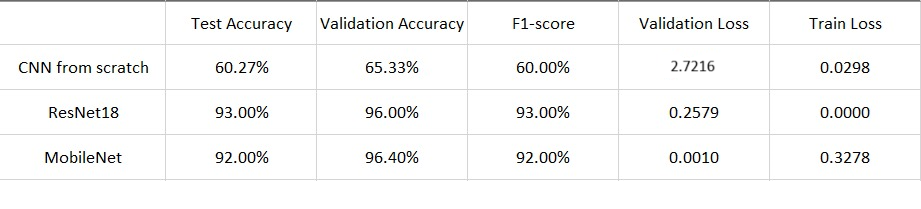

### Observations:
**Test Accuracy:**

*   CNN from scratch achieved the lowest test accuracy (60.27%), indicating poor generalization to unseen data.
*   ResNet18 and MobileNet significantly outperformed the CNN, with 93.00% and 92.00% test accuracy, respectively.
Validation Accuracy:

*   CNN reached 65.33%, further highlighting its limitations in feature learning.
*   Both ResNet18 (96.00%) and MobileNet (96.40%) showed excellent validation accuracy, with MobileNet slightly ahead.

**F1-Score:**

*   The F1-score for CNN (60.00%) correlates with its accuracy, showing it struggles to balance precision and recall.
*   ResNet18 and MobileNet achieved 93.00% and 92.00% F1-scores, respectively, with ResNet18 performing marginally better in balancing predictions across all classes.

**Validation Loss:**

*   CNN’s validation loss (2.7216) is much higher, showing its inability to minimize errors effectively.
*   ResNet18 (0.2579) and MobileNet (0.0010) had significantly lower validation losses, with MobileNet achieving the lowest, demonstrating its superior optimization.

**Train Loss:**

*   CNN had a low training loss (0.0298), suggesting overfitting, as its validation performance was significantly worse.
*   ResNet18 (0.0000) and MobileNet (0.3278) exhibited effective optimization while maintaining good validation performance.

* Discuss practical considerations when choosing between these approaches and models.

When choosing between training from scratch and using pre-trained models like ResNet18 or MobileNet, the decision depends on the dataset, resources, and goals. Training from scratch, as with the CNN in this assignment, requires more time, computational resources, and a larger dataset but allows full control over the architecture. However, it risks overfitting on smaller datasets like Animal-10 and achieved only 60% accuracy. In contrast, pre-trained models like ResNet18 and MobileNet performed significantly better, achieving over 96% accuracy due to their pre-learned features and efficient architectures. MobileNet was especially lightweight and resource-efficient, making it ideal for real-time applications. For most cases, transfer learning is the better choice for quick, accurate, and efficient results, while training from scratch is more suitable for niche tasks or learning purposes.

